# Modelo computacional para el análisis causal de políticas públicas
#### (El caso de los salario mínimos en un mercado laboral acotado)
### por Gonzalo Castañeda
#### CIDE, México (Otoño, 2022)

Propósito del modelo: mostrar las ventajas de los ABM en el estudio de las inferencias causales. A partir de esta metodología es posible construir un marco teórico que analice el impacto de ciertas intervenciones (políticas y programas) en las variables de interés.
(i) Permite generar contrafactuales para el grupo de tratamiento que son proxys apropiadas para describir escenarios que pudieron haber ocurrido post-tratamiento si la intervención no hubiera ocurrido, lo que reduce la creación de sesgos en la medición de los impactos causales.
(ii) La política se puede estudiar en contextos muy variados, e inclusive cuando no existe evidencia empírica sobre los efectos de la política a analizar, ya sea porque el entorno es otro, o bien porque las caracaterísticas específicas de las políticas ya implmentadas son diferentes.
(iii) Muestra que los estudios causales basados exclusivamente en análisis econométricos pueden ser desafortunados cuando las conclusiones obtenidas son extrapoladas para su uso en contextos diferentes. Lo que apunta a las ventajas de complementar el análisis empírico con formulaciones teóricas rigurosas. 

A manera de ilustrar la metodología se construye un ABM sencillo sobre un mercado laboral de trabajadoras domésticas acotado a un espacio geográfico (e.g., cotos residenciales), cuyo propósito es estudiar el impacto que sobre el desempleo tiene un cambio en los salarios mínimos

In [1]:
import random as rd
import numpy as np
import matplotlib.pyplot as plt

In [72]:
# Para modificar el tamaño de todos los gráficos.
from matplotlib import rcParams
rcParams['figure.figsize'] = 12,9

In [2]:
# Definición de parámetros
base = 50            # celdas (hogares) del coto residencial a estudiar
altura = 50
ocupacion = 0.6      # porcentaje de hogares que requieren trabajadoras (porcentaje de empleos máximo)
lazos = 3            # número de vínculos de amistad de las empleadas domésticas
sal_min = 3          # salario mínimo inicial

In [3]:
# Inicialización del coto y definición de las condiciones iniciales del mercado 
# laboral

def inicializar(coto):               # coto define la capacidad de pago de empleadores
    rd.seed(1234)                    # se establecen condiciones iniciales similares entre corridas        
    global mes, factibles, vacantes, salarios, sal_conv, ofertas, empleadas, des_temp
    empleadas = []                   # listado de trabajadoras domésticas
    amigas = []                      # listado de lazos de amistad de las empleadas del coto
    mes = 0
    des_temp = [0]                   # variable de resultados: número de desempleados (vacantes)
                                     # el coto se formula mediante una retícula cuadrada que en 
                                     # Python se describe con un arreglo de ceros en numpy
                                     # las condiciones de los empleadores son las siguientes:
    factibles = np.zeros([base, altura]) # cota máxima para el pago de salarios según ingreso familiar
    salarios = np.zeros([base, altura])  # salarios que cada hogar está dispuesto a pagar 
    sal_conv = np.zeros([base, altura])  # salarios convencionales producto de la influencia vecinal
    vacantes = np.zeros([base, altura])  # vacantes disponibles, 1 = plaza está ocupada
    ofertas = np.zeros([base, altura])   # ofertas laborales recibidas cuando la plaza estaba ocupada
        
                                      # exploramos el coto con un doble loop para asignar trabajadoras
                                      # en los hogares y establecer las condiciones iniciales
    for x in range(base):
        for y in range(altura):       # se inicia con salarios > minimo, pero < capacidad de pago
                                      
            #factibles[x, y] = rd.randint(20, 50)
            factibles[x, y] = rd.randint(coto, coto+30) 
                                                        # se define al azar el ingreso del empleador
                                                        # la capacidad de pago por  hogar es el  
                                                        # máximo salario posible a pagar    
          # en factibles ya se define un porcentaje del ingreso del empleador = capacidad a pagar
                                                        # Primero definimos salarios iniciales
            if coto == 20:                              # por debajo de factibilidad, de tal forma
                                                        # que todos pueden pagarlo al inicio
                salarios[x, y] = rd.randint(sal_min, (factibles[x, y]//4))
            else:                          # Aquí para hacer analisis de sensibilidad x factibilidad                      
                salarios[x, y] = rd.randint(sal_min, (coto+30)//4)   #Ojo algunos no pueden pagar
            if rd.random() < ocupacion:    # posicionamiento aleatorio de trabajadoras en el coto
                vacantes[x,y] = 1           # locación a la que se asigna la trabajadora
                plazos = rd.randint(0, 12)  # duración inicial del contrato con distintos plazos
                busquedas = 0               # búsquedas de empleo por la trabajadora
                empleadas.append([x, y, salarios[x,y], plazos, amigas, busquedas]) # listado en el que
                                            # se definen las características del trabajo: 
                                            # (0) coordenada x locación, (1) coordenada y, (2) salario
                                            # (3) plazo que resta, (4) lazos de amistad, 
                                            # (5) búsquedas de empleo realizadas una vez que termina
                                            # la relación laboral                                                                            
    sal_conv = salarios.copy()      # al inicio, el salario convencional es el generado al azar
                                            # se usa .copy para generar una matriz independiente
                                        
                                            # se establece la red de amistad de las empledas 
    for i in range(0,len(empleadas)):       # se itera sobre el indice del vector de empleadas
        indice = list(range(0,len(empleadas)))
        indice.remove(i)                # se elimina a la propia empleada
        for j in range(0,lazos+1):      # c/u tiene igual número de lazos de amistad
            azar = rd.choice(indice)    # como choice hace muestreo con reemplazo, elegimos una x una
            indice.remove(azar)         # eliminamos del índice a la amiga elegida
            amigas.append(azar)         # se van incorporando al vector las amigas seleccionadas
        empleadas[i][4] = amigas      # vector se asigna al elemento de amistades de empleadas
        amigas = []           # se vacia el vector para iniciar otra iteración con diferente empleada
    

In [4]:
# En esta rutina se actualizan las iteraciones, lo que implica ajustar vacantes, 
# calcular salarios convencionales, reajustar salarios, realizar búsquedas, recibir ofertas 
# de empleadas y calcular nivel de desempleo 
                                                   
                                            # Intervención = se activa o no;
                                            # incr_sal = nivel del nuevo salario(alto, medio, bajo)
                                            # per_inter = mes de la intervención
                                            # ana_sen = parametro para sensibilidad de analísis
def actualizar(intervencion, incr_sal, per_inter, ana_sen):
    rd.seed()          # semilla aleatoria se elimina para que haya cambios al azar en etapa iterativa
    global mes, factibles, vacantes, salarios,  ofertas, empleadas, des_temp, sal_conv, sal_min
    if intervencion == 'activada' and mes == per_inter: # en caso de intervención activa y mes 
                                                        # indicado para aplicarla
        sal_min = intervenir(incr_sal, ana_sen)    # se aplica nuevo salario mínimo según nivel
    ind1 = []                               # listado para almacenar a empledas que mantienen contrato
    ind2 = []                               # listado para almacenar empleadas cuyo contrato vence
    rompen = []                             # listado para empleadas con rompimiento contractual
    vecinos = [-1,1]                        # distancia del centro a los bordes de las vecindades
    
                                            # iteramos sobre las empleadas para checar su situación
                                            # laboral
    for i in range(0,len(empleadas)):
        if empleadas[i][3] > 0:
            empleadas[i][3] -= 1            # si contrato aún no vence se reduce el plazo en un mes
            ind1.append(i)                  # se incorpora a la lista de las que aún tienen contrato
        else:
            ind2.append(i)                  # empleadas con contrato vencido      
    s = ((base*altura*ocupacion)-des_temp[mes])*0.10   # de las gentes aún empleadas un porcentaje
                                            # rompe la relación laboral de manera idiosincrática
        
                                            # se elige al azar aquellas con contrato que terminan
                                            # su relación laboral de manera intempestiva
    for j in range(0,round(s)):
        azar = rd.choice(ind1)              # se toma del listado de las empleadas una al azar
        rompen.append(azar)                 # se incorpora su índice en un nuevo listado (rompen)
        ind1.remove(azar)                   # se elimina del listado de trabajadoras con empleo
    for i in rompen:                        # para las que rompieron con los empleadores
        empleadas[i][3] = 0                 # su contrato se finiquita y el plazo se ajusta a cero
                                            # busquedas se mantienen en 0, porque esta variable se
                                            # hace positiva cuando inicia la búsqueda de chambas
                                            # la posición de la empleda en un hogar se cambia después
                                          
                                            # se actualizan los salarios convencionales y pagados
    ant_sal = salarios.copy()               # los salarios existentes se copian en un nuevo arreglo
    for i in rompen + ind2:      # se itera sobre las empleadas sin chamba sin importar la razón
        x = empleadas[i][0]                 # se especifican sus coordenadas en el empleo previo
        y = empleadas[i][1]
        for dx in range(-1, 2):             # se itera sobre la vecinadad (tipo Moore)
            for dy in range(-1, 2):
                                            # se ajusta el salario convencional tomando la suma
                                            # del propio y de los vecinos en el periodo previo
                                            # notar que se toman fronteras periódicas
                sal_conv[x,y] += ant_sal[(x + dx) % base, (y+dy) % altura]
        sal_conv[x,y] = sal_conv[x,y]/9     # se saca el promedio
                                            # notar que los hogares solo ajustan
                                            # el salario cuando ya no existe relación contractual
        
                                            # el salario convencional se ajusta a la baja en la
                                            # medida en que crecen las peticiones laborales
                                            # en el hogar durante el lapso del plazo del contrato
        if (1 - ofertas[x,y]/12)*sal_conv[x,y] > factibles[x,y]:  #si sal_conv mayor al factible
            empleadas[i][2] = sal_min       # se asigna el mínimo
                                            # en caso contrario se toma el máximo de entre el mínimo
                                            # entre el sal_min y el convencional ajustado por fuerza
                                            # de la oferta de trabajo 
        else:           
            empleadas[i][2] = max(sal_min , (1 - ofertas[x,y]/12)*sal_conv[x,y])
                                            # para cada empleada que perdio el empleo
        ofertas[x,y] = 0      # se usan sus coordenadas para eliminar peticiones laborales en hogar
        vacantes[x,y] = 0               # se abre una vacante en ese hogar
        salarios[x,y] = empleadas[i][2] # se asigna el calculo del nuevo salario en la mariz asociada
        
                                    # el siguiente paso es iniciar la búsqueda de empleo
                                    # se inicia intentando renovar cuando la terminación 
                                    # del contrato no fue por ruptura.
    rd.shuffle(ind2)                # para evitar artefactos se aleatorizan los índices de empleadas
    ind2_bis = ind2.copy()          # se crea una copia del listado de empleadas con contrato vencido 
                                    # ya que ind2 se va a modificar en iteración
    for i in ind2_bis:              # Se itera solo sobre este tipo de desempleadas
        corte = False
        x = empleadas[i][0]         # se especifican sus coordenadas
        y = empleadas[i][1]
                                    # si salarios nuevos son mayores o iguales a los anteriores 
                                    # pero no rebasan los factible se establece el convenio laboral
                                    # suponemos que hogares nunca pagan por debajo de salario
                                    # mínimo ¿será?
        if (salarios[x,y] >= ant_sal[x,y]) and (salarios[x,y] <= factibles[x,y]):
            vacantes[x,y] = 1       # se ocuapa a la empleada
            empleadas[i][3] = 12    # reinicia el plazo del contrato
            ind2.remove(i)          # se remueve de la lista de desempleados
            
                                    # en caso de no llegar a un acuerdo se busca la chamba entre los
                                    # vecinos del antiguo empleador
        else:
            rd.shuffle(vecinos)     # se aleatorizan a los vecinos (en este caso los pasos:-1, 1)
            for dx in vecinos:
                if corte:
                    break           # para detener búsqueda en caso de encontrar empleo (ver abajo)
                for dy in vecinos:  # se toma de nueva cuenta fronteras periodicas
                                    # si salario ofrecido es mejor a anterior, el lugar está
                                    # disponible y los salarios no son excesivos
                                    # se establece un nuevo contrato
                        if (salarios[(x + dx) % base, (y+dy) % altura] >= ant_sal[x,y]) \
                           and (vacantes[(x + dx) % base, (y+dy) % altura] == 0) \
                           and (salarios[x,y] <= factibles[x,y]):
                            vacantes[(x + dx) % base,(y + dy) % altura] = 1   # se ocupa al empleado
                            empleadas[i][0] = (x + dx) % base   # se especifica su nueva locación
                            empleadas[i][1] = (y + dy) % altura
                            empleadas[i][3] = 12                 # se reinicia el plazo
                            ind2.remove(i)           # se elimina trabajador de lista de desempleaod
                            corte = True             # se interrumpe busqueda
                            break
                        else:                        
                                                     # en caso de no llegar a un convenio, el hogar lo
                                                     # registra como una solicitud laboral
                                                     # notar que no se registra por parte del empleado
                                                     # como búsqueda ya que ello ocurre solo afuera de 
                                                     # la vecindad
                            ofertas[(x + dx) % base,(y + dy) % altura] += 1
 
                                # ahora iteramos sobre todos los desempleados que aún no se colocan
                                 # independientemente de si rompieron o terminó el plazo del contrato
    ind3 = ind2 + rompen
    rd.shuffle(ind3)             # aleatorizamos la busqueda
    ind3_bis = ind3.copy()       # como ind3 lo vamos a estar cambiando en iteración hacemos una copia
    for i in ind3_bis:           # realizamos la búsqueda para cada empleado
        corte = False
        x = empleadas[i][0]      # a partir del índice especificamos sus coordenadas    
        y = empleadas[i][1]
        amigas = empleadas[i][4] # tambien se especifica al vector de amigas        
        rd.shuffle(amigas)       # se aleatorizan a las amigas
        for j in amigas:
            if empleadas[j][3] != 0:     # si la amiga todavía trabaja puede dar información de chambas
                w = empleadas[j][0]      # queremos sondear la vecindad de la amiga
                z = empleadas[j][1]
                for dw in vecinos:       # se inicia proceso de búsqueda en su vecindad
                    if corte:
                        break            # para interrumpir búsqueda
                    for dz in vecinos:
                                         # se consideran fronteras periódicas; si el nuevo salarios
                                         # es mejor, si hay vacantes disponibles y si el salario no
                                         # es excesivo se establece el convenio
                        if (salarios[(w + dw) % base, (z + dz) % altura] >= ant_sal[x,y]) \
                           and (vacantes[(w + dw) % base, (z+dz) % altura] == 0)  \
                           and (salarios[x,y] <= factibles[x,y]):
                            vacantes[(w + dw) % base, (z + dz) % altura] = 1    # se ocupa el trabajo
                            empleadas[i][0] = (w + dw) % base           # se definen nuevas coordenadas
                            empleadas[i][1] = (z + dz) % altura
                            empleadas[i][3] = 12                        # se establece nuevo plazo
                            corte = True                                # se interrumpe la búsqueda
                            break
                        else:                  # de no acordar se registra nueva solicitud de empleo
                            ofertas[(w + dw) % base,(z + dz) % altura] += 1
        if corte:
            ind3.remove(i)    # se elimina a la empleada de lista de desempleadas 
    
                                        # por último, se inicia una búsqueda al azar en el coto
                                        # solo una por mes y en hogares fuera de la vecindad
    ind3_bis = ind3.copy()       # como ind3 lo vamos a estar cambiando en iteración hacemos una copia
    for i in ind3_bis:                  # sondeamos a todas las desempleadas que quedan
        x = rd.randint(0,base-1)        # escogemos un hogar al azar
        y = rd.randint(0,altura-1)
        u = empleadas[i][0]             # especificamos las coordenadas del trabajo anterior
        v = empleadas[i][1]
        vinculos_loc = []               # listado para guardar coordenadas de vecinos originales
        for s in range((u-1) % base, (u+2) % base):         # sondemaos la vecindad actual completa 
            for t in range((v-1) % altura, (v+2) % altura):       
                vinculos_loc.append((s,t))                  # guardamos las coordenadas de vecindad  
        while (x, y) in vinculos_loc:    # si cordenadas al azar coinciden con vecindad iteramos
            x = rd.randint(0,base-1)
            y = rd.randint(0,altura-1)

        if empleadas[i][5] < 4:         # checamos que no se haya excedido en búsquedas
                                        # y a partir de ello definimos el criterio para
                                        # llegar a un acuerdo
                                        # que haya vacantes, mejores salarios, pero no excesivos
            criterio = (vacantes[x,y] == 0) and (salarios[x,y] >= ant_sal[u,v]) \
            and (salarios[x,y] <= factibles[x,y])
                                        # el criterio cambia cuando ya lleva tiempo buscando
                                        # ahora solo se requiere que haya vacantes y salario
                                        # no sea excesivo; es decir, la trabajadora acepta cualquier
                                        # salario ofrecido
        else:
            criterio = (vacantes[x,y] == 0) and (salarios[x,y] <= factibles[x,y])
                                       # si el criterio se cumple se acepta un contrato y se ajusta
                                       # información laboral
            if criterio:
                vacantes[x,y] = 1      # se ocupa el trabajo
                empleadas[i][0] = x    # se asignan el hogar elegido al azar como nuevo trabajo
                empleadas[i][1] = y
                empleadas[i][3] = 12   # se reestablece plazo del contrato
                empleadas[i][5] = 0    # se reinician búsquedas
                ind3.remove(i)         # se elimina de la lista de desempleadas
                
                                       # de no llegar a un convenio
            else:
                ofertas[x,y] += 1      # se incrementan las solicitudes laborales
                empleadas[i][5] += 1   # aumentan las búsquedas realizadas
        
    mes += 1                           # se actualiza el periodo de iteración (mes)
    des_temp.append(len(ind3))         # se actualiza listado con desempleo temporal (por mes)
   

In [5]:
# En esta rutina se define el monto del incremento salarial que se aplica cuando hay intervención 

def intervenir(incr_sal, ana_sen):   # incr_sal define el tipo de incremento entre bajo, medio y alto
    global factibles, sal_conv
    mean_conv = sal_conv[vacantes == 1].mean()  # se toma la media de los salarios convencionale
                                                # pero solo de los hogares que tienen empleada
    if incr_sal == 'marginal':
        sal_min = mean_conv*0.9 
    elif incr_sal == 'bajo':                    # para los cuatro casos (marginal, bajo, medio, alto) 
        sal_min = mean_conv*1.5                 # el mínimo es una proporción del salario convencional
    elif incr_sal == 'medio':                   # promedio
        sal_min = mean_conv*6
    else:                                                    
        sal_min = mean_conv*10

    print('Salario mínimo post-intervención =', sal_min)
    return sal_min                              # como el sal_min no se define como variable global

In [6]:
# En esta rutina se establece una simulación invocando funciones de inicializar y actualizar, en la 
# que se especifican como argumentos número de periodos, si hay intervención (activa), su magnitud,
# mes de la intervención y si hay análisis de sensibilidad con salaarios mínimos

def simular(iteraciones, intervencion, incr_sal, per_inter, coto, ana_sen):
    global des_temp
    inicializar(coto)
    for i in range (0, iteraciones+1):
        actualizar(intervencion, incr_sal, per_inter, ana_sen)       

Salario mínimo post-intervención = 3.108043047886411


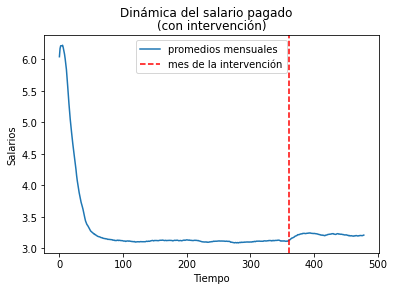

In [7]:
# Con esta rutina se analiza lo que pasaría si el modelo se corre a partir de las condiciones 
# iniciales sin incorporar un periodo de transición; además se analiza el impacto que pueden 
# tener en los salarios promedios pagados al momento de darse un incremento en salarios mínimos

inicializar(coto=20)
salar_med = []                    # listado para guardar salarios medios en el tiempo
iniciales = 240                   # se deja correr un tiempo para compensar por condiciones iniciales
per_inter = 360                   # mes de la intervención  
total = per_inter + 120           # tiempo final de la corrida
for j in range(0,total):
    actualizar('activada', 'marginal', per_inter, ana_sen=0)       # argumentos  para actualizar 
    salar_med.append(salarios[vacantes == 1].mean())    # se calculan salarios medio en hogares que
                                                        # tienen empleadas domésticas
                                                        # y se incorporan a la serie de tiempo

                                        # preparamos información para la gráfica de salarios
sal_med_obs = salar_med[1:total]        # la serie de tiempo a graficar tiene la misma extensión
plt.plot(sal_med_obs, label = "promedios mensuales")
plt.axvline(x = per_inter, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Salarios')
plt.suptitle("Dinámica del salario pagado")
plt.title('(con intervención)')
plt.legend()
plt.show()
    

Explicación (1): Debido al proceso de generación de salarios en la rutina inicializar() algunos hogares  empiezan ofreciendo salarios muy por encima de los mínimos, ya que sus capacidades económicas se lo permiten. Sin embargo, conforme pasan los meses y la gente se vuelve desocupada por terminación de contrato o ruptura, tienen que recontratarse. Estas trabajadoras tienen dificultades para encontrar salarios tan altos, por lo que a la postre tienen que aceptar salarios más bajos, ya sea porque han pasado varios meses desempleadas o porque el incremento en solicitudes de empleo hace que los empleadores ya no están dispuestos a pagar salarios tan altos.
Notar que con el tiempo el criterio de salarios convencionales lleva a una norma salarial ligeramente por encima del salario mínimo. Este resultado implica que para las simuaciones es conveniente dejar un periodo de transición hasta que la norma salarial se consolide.

Explicación (2): Al darse un incremento exógeno en los salarios mínimos, los salarios pagados repuntan ya que aquellos hogares que estaban pagando un salarios mínimo, que en su vecindad estaba por encima del convencional, se ven obligados a acatar la disposición legal y, por ello, los trabajadores recién contratados reciben mayores salarios. A su vez este incremento en salarios mínimos impulsa a la alza la norma salarial.

Salario mínimo post-intervención = 3.1101994790315426


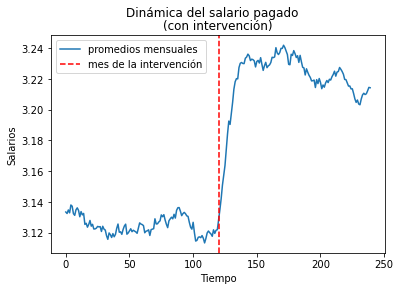

In [8]:
# Con esta rutina se hace una prueba del modelo y se checa la dinamica de los salarios pagados
# ya sea con intervencion o sin ella; se puede checar como un aumento en salarios mínimos incrementa
# los salarios promedios en general
# Cabe también notar que a lo largo del tiempo hay fluctuaciones en los salarios, inclusive sin
# intervención por efecto de las renuncias y la finalización de contratos

sal_min = 3
inicializar(coto=20)
salar_med = []                    # listado para guardar salarios medios en el tiempo
iniciales = 240                   # se deja correr un tiempo para compensar por condiciones iniciales
per_inter = iniciales + 120 + 1   # mes de la intervención
total = per_inter + 120           # tiempo final de la corrida
for j in range(0,total):
    actualizar('activada', 'marginal', per_inter, ana_sen=0)     # argumentos  para actualizar 
    salar_med.append(salarios[vacantes == 1].mean())    # se calculan salarios medio en hogares que
                                                        # tienen empleadas domésticas
                                                        # y se incorporan a la serie de tiempo

                                  # preparamos información para la gráfica de salarios
sal_med_obs = salar_med[iniciales+1:total]   # la serie de tiempo a graficar tiene la misma extensión
plt.plot(sal_med_obs, label = "promedios mensuales")
plt.axvline(x = 120, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Salarios')
plt.suptitle("Dinámica del salario pagado")
plt.title('(con intervención)')
plt.legend()
plt.show()

Salario mínimo post-intervención = 5.177551958132852


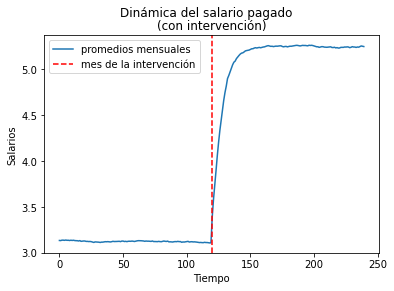

In [9]:
# Con esta rutina se muestra que el impacto en los salarios importante no proviene de la dinámica 
# mes a mes, sino más bién de la intervención en salarios mínimos. Cuando este cambio no es tan 
# marginal las fluctuaciones mensuales son de sengundo orden de importancia en relación al
# impacto del cambio exógeno
# Notar que la nueva norma salarial no queda muy por encima de los salarios mínimos, por lo que
# uno pensaría que los salarios mínimos ejercen un efecto farol (o de guía)

sal_min = 3
inicializar(coto=20)
salar_med = []                    # listado para guardar salarios medios en el tiempo
iniciales = 240                   # se deja correr un tiempo para compensar por condiciones iniciales
per_inter = iniciales + 120 + 1   # mes de la intervención
total = per_inter + 120           # tiempo final de la corrida
for j in range(0,total):
    actualizar('activada', 'bajo', per_inter, ana_sen=0)  # argumentos  para actualizar 
    salar_med.append(salarios[vacantes == 1].mean())    # se calculan salarios medio en hogares que
                                                        # tienen empleadas domésticas
                                                        # y se incorporan a la serie de tiempo

                                  # preparamos información para la gráfica de salarios
sal_med_obs = salar_med[iniciales+1:total]   # la serie de tiempo a graficar tiene la misma extensión
plt.plot(sal_med_obs, label = "promedios mensuales")
plt.axvline(x = 120, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Salarios')
plt.suptitle("Dinámica del salario pagado")
plt.title('(con intervención)')
plt.legend()

Salario mínimo post-intervención = 3.111916735789715


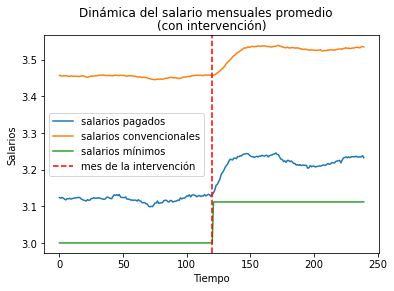

In [10]:
# En esta rutina se compara la dinámica de los salarios pagados, salarios convencionales y mínimos
# con el propósito de identificar el impacto de una alza marginal en salarios mínimos
# (i.e, por debajo de convencionales)

sal_min = 3
inicializar(coto=20)
salar_med = []                    # listado para guardar salarios medios en el tiempo
conv_med = []
iniciales = 240                   # se deja correr un tiempo para compensar por condiciones iniciales
per_inter = iniciales + 120 + 1   # mes de la intervención
total = per_inter + 120           # tiempo final de la corrida
for j in range(0,total):
    actualizar('activada', 'marginal', per_inter, ana_sen=0)           # argumentos  para actualizar 
    salar_med.append(salarios[vacantes == 1].mean())    # se calculan salarios medio y convencionales
    conv_med.append(sal_conv[vacantes == 1].mean())     # en hogares que tienen empleadas domésticas
                                                        # y se incorporan a la serie de tiempo

                                  # preparamos información para la gráfica de salarios

sal_med_obs = salar_med[iniciales+1:total]   # la serie de tiempo a graficar tiene la misma extensión
conv_med_obs = conv_med[iniciales+1:total]
sal_min_obs= []
for i in range(iniciales+1 , total):
    if i <= per_inter:
        sal_min_obs.append(3)
    else:
        sal_min_obs.append(sal_min)
plt.plot(sal_med_obs, label = "salarios pagados")
plt.plot(conv_med_obs, label = "salarios convencionales")
plt.plot(sal_min_obs, label = "salarios mínimos")
plt.axvline(x = 120, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Salarios')
plt.suptitle("Dinámica del salario mensuales promedio")
plt.title('(con intervención)')
plt.legend()

Explicación (1): En el periodo pre-intervención, un primer grupo de hogares paga un salario convencional alto (los menos), mientras que un segundo grupo paga un salario mínimo o salarios convencionales muy bajos, por lo que el salario pagado se encuentra entre los dos, pero más cercano a la línea de salarios mínimos. 

Explicación (2): En el periodo post-intervención, los salarios mínimos aumentan y con ello impulsan a la alza la norma salarial. Esto puede dislocar el mercado laboral (aumentar el desempleo) en la medida en que un mayor número de trabajadoras al terminar su contrato o renunciar deciden esperar más tiempo para tomar un empleo. En otras palabras, el alza marginal de salarios mínimos queda por debajo de los convencionales pre-interveción, lo que provoca un escenario en el que las ofertas salariales propuestas en muchos hogares con vacantes queden por debajo del salario previo de los que buscan empleo, lo que lleva a incrementar el tiempo de desocupación.  

Salario mínimo post-intervención = 5.179037032774953


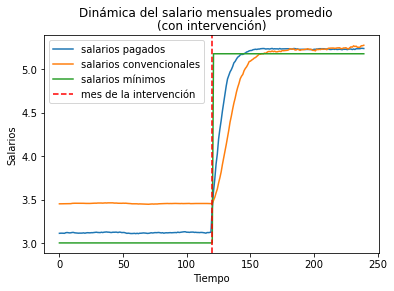

In [11]:
# En esta rutina se compara la dinámica de los salarios pagados, salarios convencionales y mínimos
# con el propósito de identificar el impacto de un aumento en salarios mínimos 'bajo', en vex de 
# marginal
# (i.e, por arriba de los salarios convencionales pre-intervención, pero aún lo suficientemente
# bajos como para no exceder la capacidad de pago de los hogares)

sal_min = 3
inicializar(coto=20)
salar_med = []                    # listado para guardar salarios medios en el tiempo
conv_med = []
iniciales = 240                   # se deja correr un tiempo para compensar por condiciones iniciales
per_inter = iniciales + 120 + 1   # mes de la intervención
total = per_inter + 120           # tiempo final de la corrida
for j in range(0,total):
    actualizar('activada', 'bajo', per_inter, ana_sen=0)           # argumentos  para actualizar 
    salar_med.append(salarios[vacantes == 1].mean())    # se calculan salarios medio y convencionales
    conv_med.append(sal_conv[vacantes == 1].mean())     # en hogares que tienen empleadas domésticas
                                                        # y se incorporan a la serie de tiempo

                                  # preparamos información para la gráfica de salarios
sal_med_obs = salar_med[iniciales+1:total]   # la serie de tiempo a graficar tiene la misma extensión
conv_med_obs = conv_med[iniciales+1:total]
sal_min_obs= []
for i in range(iniciales+1 , total):
    if i <= per_inter:
        sal_min_obs.append(3)
    else:
        sal_min_obs.append(sal_min)
plt.plot(sal_med_obs, label = "salarios pagados")
plt.plot(conv_med_obs, label = "salarios convencionales")
plt.plot(sal_min_obs, label = "salarios mínimos")
plt.axvline(x = 120, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Salarios')
plt.suptitle("Dinámica del salario mensuales promedio")
plt.title('(con intervención)')
plt.legend()

Explicación: Con salarios bajos (i.e., que no exceden la capacidad de pago de los hogares), no solo
se produce un efecto disruptivo en la norma salarial, sino también salarios pagados que exceden 
a los convencionales, lo que produce gran interés de los trabajadores a conseguir empleo de inmediato
y, de esta, manera se puede producir una disminución en la tasa de desocupación, como se verá más adelante.

In [12]:
# En esta rutina se hace una corrida a manera de ejemplo, la que corre (después del periodo de 
# depuración) 120 meses pre-intervención y 120 meses post-intervención
# Se aplica solamente la Diferencia post-intervención para calcular el impacto que 
# tiene un aumento en el salario mínimo sobre el desempleo

sal_min = 3                     # se tiene que volver a especificar el sal_min por si hubo corrida
                                # previa en la que se modificaron
iniciales = 240
per_inter = iniciales + 120 + 1
total = per_inter + 120
simular(total, 'no_activada', 'bajo', per_inter, coto=20, ana_sen=0)  # en esta corrida no hay intervención
des_temp_noact = des_temp               # listado con datos de desempleo para serie contrafactual
                                        # es decir, sin la intervención
simular(total, 'activada', 'bajo', per_inter, coto=20, ana_sen=0)  # en esta corrida si hay intervención   
des_temp_act = des_temp                 # listado con datos de desempleo c/intervención      
dif_post_int = []                       # Listado para diferencias con datos de c/mes
                                        # en el periodo post-intervención
for item1, item2 in zip(des_temp_act[per_inter:total], des_temp_noact[per_inter:total]):
        item = item1 - item2
        dif_post_int.append(item)      # se van agregando diferencias en pre-intervención
                                       # se imprimen datos de las primeras diferencias:
print('Media de la diferencia de desocupación post-intervención =', np.mean(dif_post_int))

Salario mínimo post-intervención = 5.175482961981656
Media de la diferencia de desocupación post-intervención = -35.03333333333333


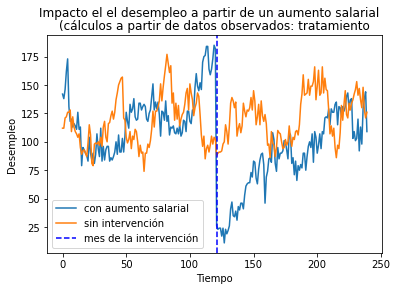

In [13]:
# Rutina de graficación para ilustrar el impacto que tiene la intervención sobre el desempleo
# a través del tiempo, y se hace una comparación con el contrafactual (sin intervención)


des_temp_act_obs= des_temp_act[iniciales+1:total]     # serie de desempleo con intervención
des_temp_noact_obs= des_temp_noact[iniciales+1:total] # serie de desempleo sin intervención
plt.plot(des_temp_act_obs, label = "con aumento salarial")
plt.plot(des_temp_noact_obs, label = "sin intervención")
plt.axvline(x = 121, color = 'b', linestyle='dashed', label = 'mes de la intervención')
plt.xlabel('Tiempo')
plt.ylabel('Desempleo')
plt.title('(cálculos a partir de datos observados: tratamiento')
plt.suptitle('Impacto el el desempleo a partir de un aumento salarial')
plt.legend()
plt.show()

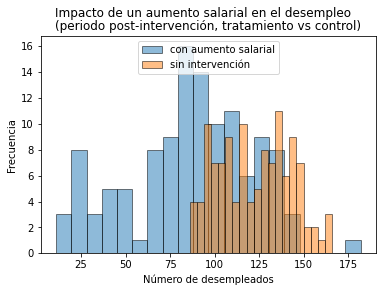

In [14]:
# Rutina de graficación de histogramas traslapados para ilustrar 
# las distribuciones temporales del desempleo en series intervenida y contrafactual

des_post_act = des_temp_act[per_inter:total]       # datos artificiales en periodo post-intervención
des_post_noact = des_temp_noact[per_inter:total]
plt.hist(des_post_act, bins=20, edgecolor='black', alpha = 0.5, label = 'con aumento salarial')
plt.hist(des_post_noact, bins=20, edgecolor='black', alpha = 0.5, label = 'sin intervención')
plt.xlabel('Número de desempleados')
plt.ylabel('Frecuencia')
plt.title("(periodo post-intervención, tratamiento vs control)")
plt.suptitle("Impacto de un aumento salarial en el desempleo")
plt.legend(loc='upper center')
plt.show()

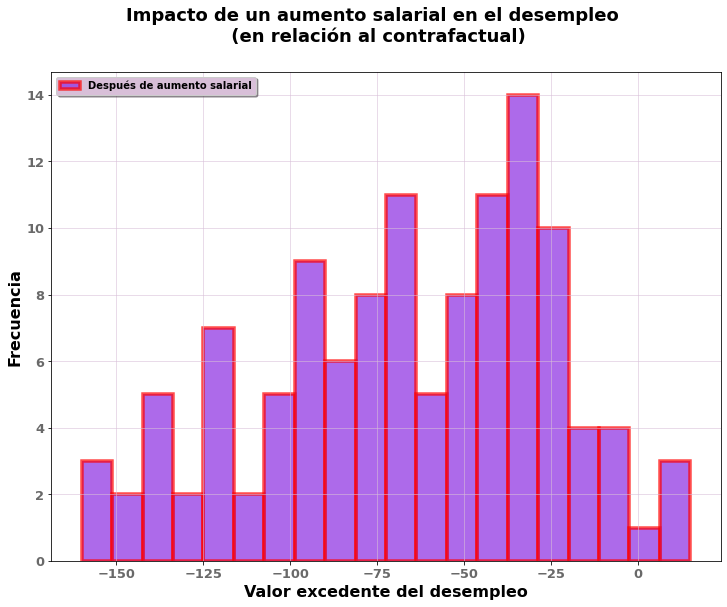

In [76]:
# Histograma que muestra datos mensuales de las diferencias en desempleo después de la 
# intervención (i.e., con respecto al contrafactual)

plt.hist(dif_post_int, bins = 20, edgecolor = 'red',
         alpha = 0.7, linewidth = 3.5, color = 'blueviolet',
         label = 'Después de aumento salarial')
plt.xlabel('Valor excedente del desempleo',
           fontsize = 16, fontweight = 'bold',
           color = 'black')
plt.ylabel('Frecuencia',
           fontsize = 16, fontweight = 'bold',
           color = 'black')
plt.xticks(fontsize = 13, fontweight = 'bold', 
           rotation = 0, color = 'dimgrey')
plt.yticks(fontsize = 13, fontweight = 'bold',
           color = 'dimgrey')
plt.suptitle("Impacto de un aumento salarial en el desempleo \n (en relación al contrafactual)",
              fontsize = 18,
              color = 'black', 
              fontweight = 'bold')
plt.legend(fontsize = 14, facecolor = 'thistle',
           loc = 'upper left', fancybox = 'True',
           shadow = 'True', prop = {'weight':'bold'})
plt.grid(color = 'thistle', alpha = 0.7,
         linestyle = '-')
plt.show()

In [16]:
# Se corre la simulación sin intervención para ilustrar la dinámica del desempleo
# el objetivo es mostrar que en un momento dado el desempleo puede crecer (o decrecer) sin necesidad de
# que se produzca una intervención. No obstante, ello no implica que sea necesario aplicar un DiD
# en el que una primera diferencia inter-temporal elimina efectos fijos
# Esto se debe a que el contrafactual es el mismo modelo de generación de datos, por lo que
# la serie intervenida también exhibiría esta tendencia 'natural' que se combina con el efecto de la
# intervención

sal_min = 3
iniciales = 240
per_inter = iniciales + 120 + 1
total = per_inter + 120
simular(total, 'no-activada', 'bajo', per_inter, coto= 20, ana_sen=0)
print('Media de la desocupación periodo inicial=', np.mean(des_temp[iniciales+1:per_inter]))
print('Media de la desocupación periodo final=', np.mean(des_temp[per_inter:total]))
print('Media de la diferencia en desocupación=', np.mean(des_temp[per_inter:total])- np.mean(des_temp[iniciales+1:per_inter]))

Media de la desocupación periodo inicial= 122.35
Media de la desocupación periodo final= 115.275
Media de la diferencia en desocupación= -7.074999999999989


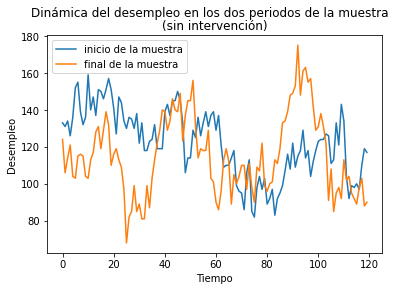

In [17]:
#Rutina de graficación para mostrar dinámica de desempleo sin intervención


des_temp_inicio = des_temp[iniciales+1:per_inter]
des_temp_final = des_temp[per_inter:total]
plt.plot(des_temp_inicio, label = "inicio de la muestra")
plt.plot(des_temp_final, label = "final de la muestra")
plt.xlabel('Tiempo')
plt.ylabel('Desempleo')
plt.suptitle("Dinámica del desempleo en los dos periodos de la muestra \n (sin intervención)")
plt.legend()
plt.show()

In [18]:
# Simulaciones de Monte Carlo en las que se corre el modelo N número de veces  


Dif_medias_pos = [] #listado para guardar los promedios de las diferencias mensuales post-intervención
Medias_pre = [] # Listado para guardar promedios del desempleo pre-intervención
batch_dif = []  # listado para incorporar las diferencias mensuales post-intervención de cada corrida
for j in range(0,150):
    print('iteración número =', j+1)
    sal_min = 3
    iniciales = 240
    per_inter = iniciales + 120 + 1
    total = per_inter + 120 
    dif_post_int = []      # listado para ir guardando las diferencias mensuales post-intervención
    simular(total, 'no_activada', 'bajo', per_inter, coto= 20, ana_sen=0)
    des_temp_noact = des_temp
    simular(total, 'activada', 'bajo', per_inter, coto=20, ana_sen=0)
    des_temp_act = des_temp
    for item1, item2 in zip(des_temp_act[per_inter:total], des_temp_noact[per_inter:total]):
        item = item1 - item2
        dif_post_int.append(item)
    #print('Media de la diferencia de desocupación post-intervención =', np.mean(dif_post_int))
    Dif_medias_pos.append(np.mean(dif_post_int)) # se calculo el promedio del desempleo generado
                                                 # en periodo postintervención en serie intervenida
                                                 # mensual (diferencias versus contrafactual)
    Medias_pre.append(np.mean(des_temp_act[iniciales+1:per_inter])) # Promedio mensual del desempleo
                                                                    # pre-intervención
    batch_dif.append(dif_post_int)                # creo una lista de listas, en la que cada una
                                                  # describe la dinamica en el tiempo de 
                                                  # las intervenciones

iteración número = 1
Salario mínimo post-intervención = 5.1733414300075875
iteración número = 2
Salario mínimo post-intervención = 5.181532438572003
iteración número = 3
Salario mínimo post-intervención = 5.1810845575453675
iteración número = 4
Salario mínimo post-intervención = 5.183655153988591
iteración número = 5
Salario mínimo post-intervención = 5.193154643795637
iteración número = 6
Salario mínimo post-intervención = 5.153028101963165
iteración número = 7
Salario mínimo post-intervención = 5.184997432776994
iteración número = 8
Salario mínimo post-intervención = 5.172747971587678
iteración número = 9
Salario mínimo post-intervención = 5.184258432666249
iteración número = 10
Salario mínimo post-intervención = 5.171243297481066
iteración número = 11
Salario mínimo post-intervención = 5.189184418196304
iteración número = 12
Salario mínimo post-intervención = 5.1841706661531965
iteración número = 13
Salario mínimo post-intervención = 5.169165991509345
iteración número = 14
Salario m

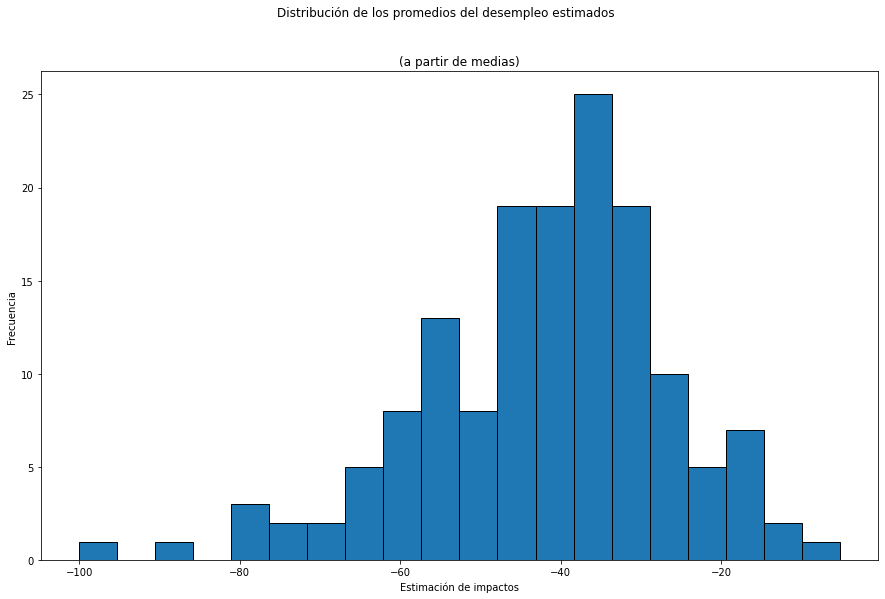

Impacto medio en el desempleo = -41.88566666666667
Impacto medio en el desempleo en relación al contrafactual= -35.263462651997685 %


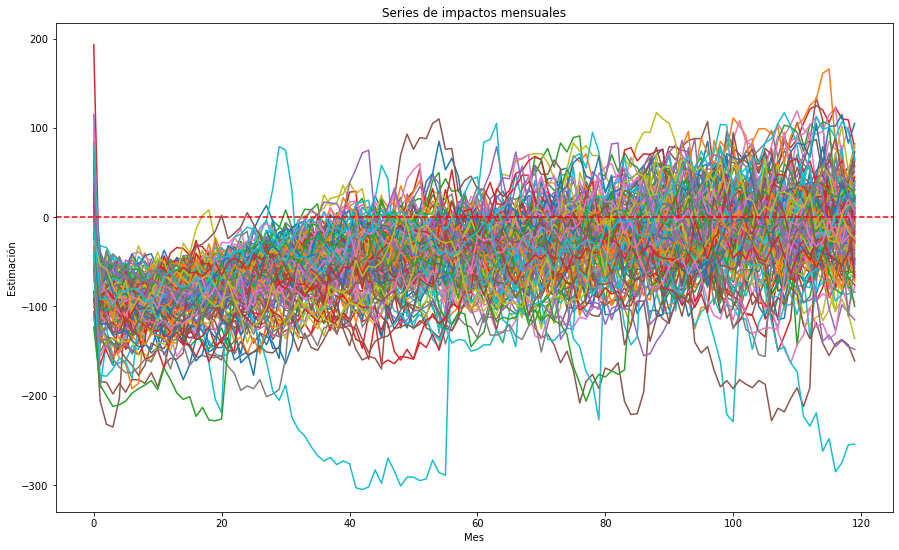

In [69]:
# Histogramas en que se muestran las estimaciones de los promedios de las diferencias mensuales
# en el desempleo post-intervención para las N simulaciones de Monte Carlo

plt.hist(Dif_medias_pos, bins = 20, edgecolor='black')
plt.xlabel('Estimación de impactos')
plt.ylabel('Frecuencia')
plt.title("(a partir de medias)")
plt.suptitle("Distribución de los promedios del desempleo estimados")
plt.show()
print('Impacto medio en el desempleo =', np.mean(Dif_medias_pos))
a = (np.mean(Dif_medias_pos)/np.mean(Medias_pre))*100
print('Impacto medio en el desempleo en relación al contrafactual=', a, '%')

# Con esta gráfica se visualizan las series de diferencias mensuales post-intervención que se 
# con las distintas corridas de Monte Carlo 

for i in batch_dif:
    plt.plot(i)
plt.xlabel('Mes')
plt.ylabel('Estimación')
plt.title("Series de impactos mensuales")
plt.axhline(y = 0, color = 'r', linestyle='dashed', label = 'mes de la intervención')
plt.show()

Exlicación histograma: Notar que todos los impactos son negativos; es decir, hubo una reducción del desempleo. El desempleo medio bajo en 45 unidades, en el promedio de las corridas de Monte Carlo; cifra que comparada con el desempleo promedio pre-intervención significa una caida del 38.3%
La ventaja de obtener estas distribuciones es que sabemos el grado estadístico de significancia;
es decir, la probabilidad de la hipótesis nula de no significancia del impacto es del 0%

Explicación series de diferencias: Notar que en todas las corridas hubo un rápido decremento del
desempleo, el que se sostuvo así para muchas corridas durante los 120 meses post-inversión,
Sin embargo, si hay un número significativo de corridas, en las que al paso de los meses el desempleo
se incrementó contra el contrafactual, haciendo que la diferencia se volviera positiva. 
En general la tendencia creciente del diferencial de desempleo indicaría que el impacto inicial de
menos desempleo que genera el aumento en salarios mínimos se revierte, o por lo menos se reduce en magnitud.
También llama la atención de que pueden existir corridas atípicas como la de laa de las líneas extremas en la parte inferior del diagrama, ello se debe a los efectos no-lineales de los sistemas complejos.


In [20]:
# El propósito de esta rutina es modificar la función (intervenir) para realizar análisis de
# sensibilidad y así checar el impacto que tiene el alza en salarios mínimos sobre el
# desempleo medido usando el criterio de estimación de diferencias post-tratamiento

def intervenir(incr_sal, ana_sen):  # incr_sal define el tipo de incremento entre bajo, medio y alto
    global factibles, sal_conv
    mean_conv = sal_conv[vacantes == 1].mean()  # se toma la media de los salarios convencionales
    sal_min = mean_conv*(0.7+ana_sen)           # se generan incrementos paulatinos en los salarios                                    # mínimos
    print('Salario mínimo post-intervención =', sal_min)
    return sal_min

In [21]:
# En esta rutina se lleva a cabo el análisis de sensibilidad del incremento en salarios mínimos de
# distinta magnitud, en los primeros casos se trata de alzas marginales en las que los salarios 
# mínimos se incrementan por debajo de los convencionales del periodo pre-intervención
# Los siguientes escenarios corresponden a escenarios bajos en los que el salario supera a los
# convencionales, pero no lo suficiente para exceder la capacidad de pago de los hogares
# El el úntimo escenario, cada vez más hogares empiezan a observar salarios mínimos que exceden sus 
# capacidades financieras

Dif_sens = []
ana_sen = 0
for k in range (0, 30):
    sal_min = 3                    
    iniciales = 240
    per_inter = iniciales + 120 + 1
    total = per_inter + 120
    simular(total, 'no_activada', 'bajo', per_inter, 20, ana_sen)  # en esta corrida no hay intervención
    des_temp_noact = des_temp               # listado con datos de desempleo para serie contrafactual
                                        # es decir, sin la intervención
    simular(total, 'activada', 'bajo', per_inter, 20, ana_sen)  # en esta corrida si hay intervención   
    des_temp_act = des_temp                 # listado con datos de desempleo c/intervención      
    dif_post_int = []                      # Listado para primeras diferencias con datos de c/mes
                                       # en el periodo post-intervención
    for item1, item2 in zip(des_temp_act[per_inter:total], des_temp_noact[per_inter:total]):
        item = item1 - item2
        dif_post_int.append(item)      # se van agregando diferencias en pre-intervención
                                       # se imprimen datos de las primeras diferencias:
    #print('Media de la diferencia de desocupación post-intervención =', np.mean(dif_post_int))
                                      
    Dif_sens.append(np.mean(dif_post_int))   # Se saca el promedio de las diferencias
                                                   # mensuales del desempleo (vs contrafactual)
                                                   # y se van agregando al listado de promedios
                                                   # por corrida
    ana_sen += 0.2


Salario mínimo post-intervención = 2.4198449401296758
Salario mínimo post-intervención = 3.105287637849615
Salario mínimo post-intervención = 3.800700012244516
Salario mínimo post-intervención = 4.483598252819152
Salario mínimo post-intervención = 5.152871304489664
Salario mínimo post-intervención = 5.874776284470873
Salario mínimo post-intervención = 6.554750678323258
Salario mínimo post-intervención = 7.2366853286587745
Salario mínimo post-intervención = 7.918202317661184
Salario mínimo post-intervención = 8.652184877104952
Salario mínimo post-intervención = 9.335046712954965
Salario mínimo post-intervención = 10.023103259483717
Salario mínimo post-intervención = 10.706811042200016
Salario mínimo post-intervención = 11.409492200420779
Salario mínimo post-intervención = 12.042982225867732
Salario mínimo post-intervención = 12.73543838056114
Salario mínimo post-intervención = 13.471580506877883
Salario mínimo post-intervención = 14.154346907196558
Salario mínimo post-intervención = 14.

vector de impactos estimados para distintos niveles de alzas en salarios mínimos = [-19.008333333333333, 14.783333333333333, -18.325, -39.225, -37.916666666666664, -40.85, -46.18333333333333, -65.65833333333333, -59.425, -67.44166666666666, -60.06666666666667, -46.5, -39.483333333333334, -65.76666666666667, -60.475, -44.34166666666667, -52.375, -72.35, -61.99166666666667, -52.391666666666666, -53.958333333333336, -82.95, -58.9, -70.775, -58.09166666666667, -52.175, 371.45, 487.19166666666666, 543.625, 611.6]


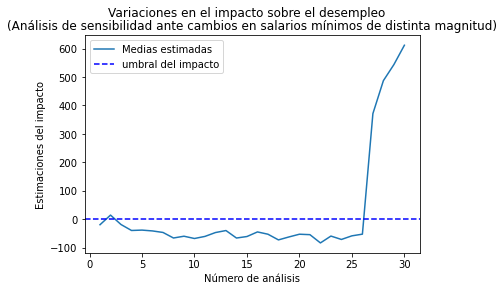

In [22]:
# En esta rutina se grafica la evolución de las estimaciones en diferencias post-interveción
# para promedios del desempleo a partir de análisis de sensibilidad con alzas crecientes 
# en los salarios mínimos

print('vector de impactos estimados para distintos niveles de alzas en salarios mínimos =', Dif_sens)
analisis = list(range(1, len(Dif_sens)+1))
plt.plot(analisis, Dif_sens, label = "Medias estimadas")
plt.axhline(y = 0, color = 'b', linestyle='dashed', label = 'umbral del impacto')
plt.xlabel('Número de análisis')
plt.ylabel('Estimaciones del impacto')
plt.suptitle("Variaciones en el impacto sobre el desempleo")
plt.title('(Análisis de sensibilidad ante cambios en salarios mínimos de distinta magnitud)')
plt.legend()
plt.show()

In [23]:
# En esta rutina se presenta un análisis de sensibilidad en el que se generan 17 cotos diferentes, los
# cuales varían en función de la capacidad de los hogares  para generar ingresos con los que 
# pagar salarios

Dif_sens = []
coto = 4
for k in range (0, 17):
    sal_min = 3                    
    iniciales = 240
    per_inter = iniciales + 120 + 1
    total = per_inter + 120
    simular(total, 'no_activada', 'bajo', per_inter, coto, ana_sen=2.3)  # en esta corrida no hay
                                            # intervención.  
    des_temp_noact = des_temp               # listado con datos de desempleo para serie contrafactual
                                            # es decir, sin la intervención
    simular(total, 'activada', 'bajo', per_inter, coto, ana_sen=2.3)  # en esta corrida si hay 
                                                                      # intervención
                                            # Notar se considera que el aumento en sal_min es fijo
    des_temp_act = des_temp                 # listado con datos de desempleo c/intervención      
    dif_post_int = []                      # Listado para diferencias con datos de c/mes
                                           # en el periodo post-intervención
    for item1, item2 in zip(des_temp_act[per_inter:total], des_temp_noact[per_inter:total]):
        item = item1 - item2
        dif_post_int.append(item)      # se van agregando diferencias en pre-intervención
                                       # se imprimen datos de las primeras diferencias:
    #print('Media de la diferencia de desocupación post-intervención =', np.mean(dif_post_int))
                                       # se imprimen datos de las segundas diferencias
    Dif_sens.append(np.mean(dif_post_int))   # Se saca el promedio de las diferencias
                                                   # mensuales del desempleo (vs contrafactual)
                                                   # y se van agregando al listado de promedios
                                                   # por corrida
    coto += 1


Salario mínimo post-intervención = 10.353242799553982
Salario mínimo post-intervención = 10.367576170739717
Salario mínimo post-intervención = 10.349954376161211
Salario mínimo post-intervención = 10.370327850095508
Salario mínimo post-intervención = 10.357174964294016
Salario mínimo post-intervención = 10.355672558564379
Salario mínimo post-intervención = 10.366293174518468
Salario mínimo post-intervención = 10.342322106986018
Salario mínimo post-intervención = 10.350467541061754
Salario mínimo post-intervención = 10.354298580591042
Salario mínimo post-intervención = 10.312769035520802
Salario mínimo post-intervención = 10.369256947865866
Salario mínimo post-intervención = 10.375589451013669
Salario mínimo post-intervención = 10.33988076770914
Salario mínimo post-intervención = 10.324659513389166
Salario mínimo post-intervención = 10.351771569872671
Salario mínimo post-intervención = 10.380977052748142


vector de estimaciones de impacto para cotos con distintas capacidades de pago = [911.1166666666667, 851.8333333333334, 742.3333333333334, 718.8333333333334, 671.925, 548.3666666666667, 417.2, -60.56666666666667, -36.833333333333336, -60.733333333333334, -50.625, -68.14166666666667, -48.25833333333333, -46.775, -37.916666666666664, -40.80833333333333, -66.58333333333333]


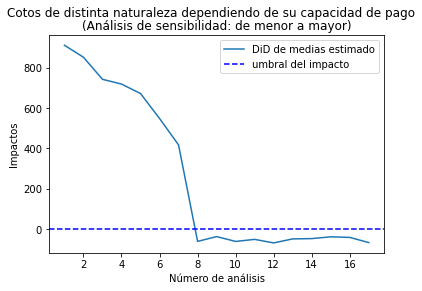

In [24]:
# En esta rutina se grafica la evolución de las estimaciones de las diferencias
# post-intervención del desempleo (promedios de diferencias mensuales)
# a partir de alzas crecientes en la capacidad de pago de los hogares de 17 cotos

print('vector de estimaciones de impacto para cotos con distintas capacidades de pago =', Dif_sens)
analisis = list(range(1, len(Dif_sens)+1))
plt.plot(analisis, Dif_sens, label = "DiD de medias estimado")
plt.axhline(y = 0, color = 'b', linestyle='dashed', label = 'umbral del impacto')
plt.xlabel('Número de análisis')
plt.ylabel('Impactos')
plt.suptitle("Cotos de distinta naturaleza dependiendo de su capacidad de pago")
plt.title('(Análisis de sensibilidad: de menor a mayor)')
plt.legend()
plt.show()

Este análisis muestra que si se toman unidades de análisis que discrepan en un factor fundamental, en
este caso capacidad de pago de los hogares, un mismo incremento en salarios mínimos va a producir resultados muy diferente en el impacto sobre el desempleo. Por ello este tipo de pooling en un 
modelo econométrico de DiDs va a genarar un resutado promedio que no es representativo de las unidades analizadas (i.e., los cotos)